In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

print(torchvision.__version__)

import os
import cv2
from torch.utils.data import Dataset
from natsort import natsorted
import pandas as pd
import numpy as np

import random

0.20.1+cu124


In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!unzip dl-2025-competition-1.zip -d dl-2025-competition-1

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dl-2025-competition-1/data/train/48/1439.png  
  inflating: dl-2025-competition-1/data/train/48/1440.png  
  inflating: dl-2025-competition-1/data/train/48/1441.png  
  inflating: dl-2025-competition-1/data/train/48/1442.png  
  inflating: dl-2025-competition-1/data/train/48/1443.png  
  inflating: dl-2025-competition-1/data/train/48/1444.png  
  inflating: dl-2025-competition-1/data/train/48/1445.png  
  inflating: dl-2025-competition-1/data/train/48/1446.png  
  inflating: dl-2025-competition-1/data/train/48/1447.png  
  inflating: dl-2025-competition-1/data/train/48/1448.png  
  inflating: dl-2025-competition-1/data/train/48/1449.png  
  inflating: dl-2025-competition-1/data/train/49/1626.png  
  inflating: dl-2025-competition-1/data/train/49/1627.png  
  inflating: dl-2025-competition-1/data/train/49/1628.png  
  inflating: dl-2025-competition-1/data/train/49/1629.png  
  inflating: dl-2025-competition

In [ ]:
base_dir = "/content/dl-2025-competition-1/data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("Train exists:", os.path.exists(train_dir))
print("Test exists:", os.path.exists(test_dir))

train_images = []
train_labels = []

for class_id in range(100):
    class_dir = os.path.join(train_dir, str(class_id))
    images = sorted(glob(os.path.join(class_dir, "*.png")))
    train_images.extend(images)
    train_labels.extend([class_id] * len(images))

test_images = sorted(glob(os.path.join(test_dir, "*.png")))

print("\nTotal train images:", len(train_images))
print("Total test images:", len(test_images))
print("\nExample train paths:", train_images[:3])
print("Example test paths:", test_images[:3])

class_counts = pd.Series(train_labels).value_counts().sort_index()
print("\nClass distribution:")
print(class_counts.head(10))

Train exists: True
Test exists: True

Total train images: 9510
Total test images: 3878

Example train paths: ['/content/dl-2025-competition-1/data/train/0/5926.png', '/content/dl-2025-competition-1/data/train/0/5927.png', '/content/dl-2025-competition-1/data/train/0/5928.png']
Example test paths: ['/content/dl-2025-competition-1/data/test/0.png', '/content/dl-2025-competition-1/data/test/1.png', '/content/dl-2025-competition-1/data/test/10.png']

Class distribution:
0    110
1    109
2    143
3    119
4    136
5     45
6    123
7    137
8     45
9     49
Name: count, dtype: int64


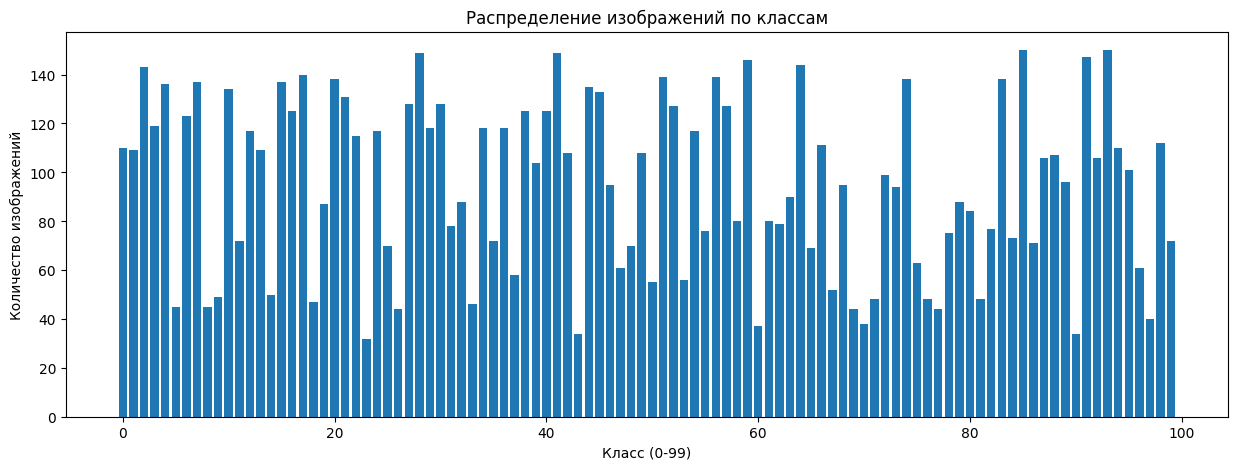

Минимальное количество изображений в классе: 32
Максимальное количество изображений в классе: 150
Среднее количество изображений: 95.1


In [ ]:
class_counts = pd.Series(train_labels).value_counts().sort_index()

plt.figure(figsize=(15, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Класс (0-99)")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.show()

print("Минимальное количество изображений в классе:", class_counts.min())
print("Максимальное количество изображений в классе:", class_counts.max())
print("Среднее количество изображений:", class_counts.mean())

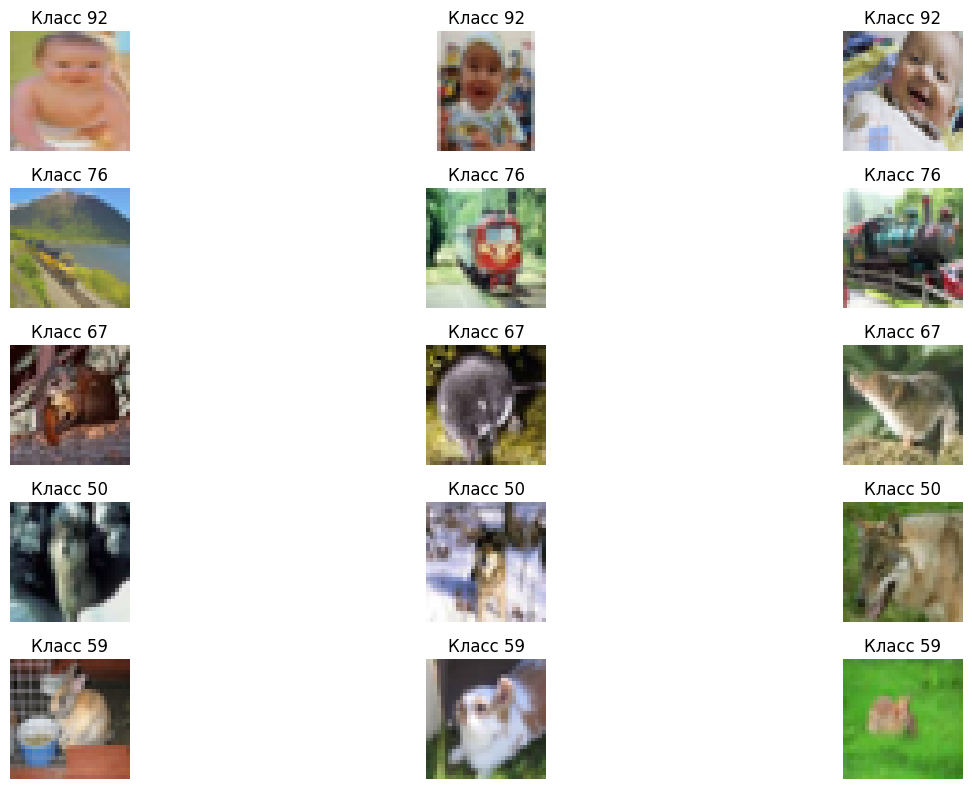

In [ ]:
random_classes = random.sample(range(100), 5)

plt.figure(figsize=(15, 8))

for i, class_id in enumerate(random_classes):
    class_images = [img for img, lbl in zip(train_images, train_labels) if lbl == class_id]
    sample_images = random.sample(class_images, 3)

    for j, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(5, 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"Класс {class_id}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.LongestMaxSize(max_size=256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),

    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
    A.MotionBlur(p=0.1),

    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=0,
        p=0.3
    ),

    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.LongestMaxSize(max_size=256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),
    A.CenterCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):

        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]


        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, label

In [ ]:
train_dataset = CustomDataset(train_imgs, train_lbls, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_lbls, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([40, 27, 99, 81, 44, 48, 86, 42, 80, 30, 49,  7, 11, 49,  7, 19, 24, 49,
        17, 95,  5, 15, 25, 29, 46, 32, 88, 48, 40,  7, 12, 11])


In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256*28*28, 1024)
        self.fc2 = nn.Linear(1024, 100)  # 100 классов

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
from torchvision import models, transforms
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Получаем количество входных признаков для последнего слоя
num_ftrs = model.classifier[1].in_features

# Заменяем последний слой на классификацию 100 классов
model.classifier[1] = nn.Linear(num_ftrs, 100)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.5MB/s]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.5192, Train Accuracy: 16.57%
Validation Loss: 2.9981, Validation Accuracy: 27.18%
Epoch 2/20, Train Loss: 2.6852, Train Accuracy: 30.28%
Validation Loss: 2.4391, Validation Accuracy: 35.86%
Epoch 3/20, Train Loss: 2.3722, Train Accuracy: 36.49%
Validation Loss: 2.2810, Validation Accuracy: 39.33%
Epoch 4/20, Train Loss: 2.1496, Train Accuracy: 41.48%
Validation Loss: 2.2050, Validation Accuracy: 41.96%
Epoch 5/20, Train Loss: 1.9960, Train Accuracy: 44.65%
Validation Loss: 1.9684, Validation Accuracy: 46.16%
Epoch 6/20, Train Loss: 1.8806, Train Accuracy: 47.75%
Validation Loss: 1.9396, Validation Accuracy: 48.48%
Epoch 7/20, Train Loss: 1.7668, Train Accuracy: 50.35%
Validation Loss: 1.9156, Validation Accuracy: 48.84%
Epoch 8/20, Train Loss: 1.3009, Train Accuracy: 62.30%
Validation Loss: 1.4592, Validation Accuracy: 58.68%
Epoch 9/20, Train Loss: 1.0877, Train Accuracy: 67.93%
Validation Loss: 1.4357, Validation Accuracy: 60.46%
Epoch 10/20, Train Loss: 1.0

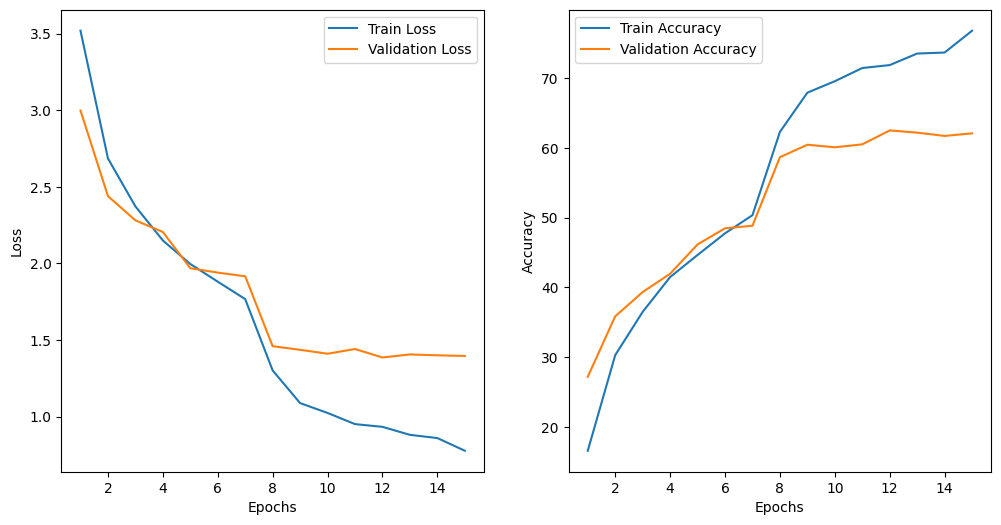

In [ ]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
from glob import glob
import pandas as pd
import torch

# Кастомный датасет
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_2.csv", index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'


In [ ]:
model = models.resnet18(pretrained=True)

# Заменяем последний слой на 100 классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.8771, Train Accuracy: 11.72%
Validation Loss: 3.4248, Validation Accuracy: 18.24%
Epoch 2/20, Train Loss: 2.9790, Train Accuracy: 25.71%
Validation Loss: 2.7156, Validation Accuracy: 32.97%
Epoch 3/20, Train Loss: 2.5837, Train Accuracy: 32.47%
Validation Loss: 2.5506, Validation Accuracy: 35.96%
Epoch 4/20, Train Loss: 2.2788, Train Accuracy: 40.26%
Validation Loss: 2.2507, Validation Accuracy: 40.96%
Epoch 5/20, Train Loss: 2.0885, Train Accuracy: 43.90%
Validation Loss: 2.0751, Validation Accuracy: 43.69%
Epoch 6/20, Train Loss: 1.9266, Train Accuracy: 47.54%
Validation Loss: 2.1294, Validation Accuracy: 43.48%
Epoch 7/20, Train Loss: 1.7490, Train Accuracy: 51.46%
Validation Loss: 2.0269, Validation Accuracy: 47.69%
Epoch 8/20, Train Loss: 1.2704, Train Accuracy: 64.60%
Validation Loss: 1.5310, Validation Accuracy: 56.94%
Epoch 9/20, Train Loss: 1.0958, Train Accuracy: 69.98%
Validation Loss: 1.5003, Validation Accuracy: 58.20%
Epoch 10/20, Train Loss: 1.0

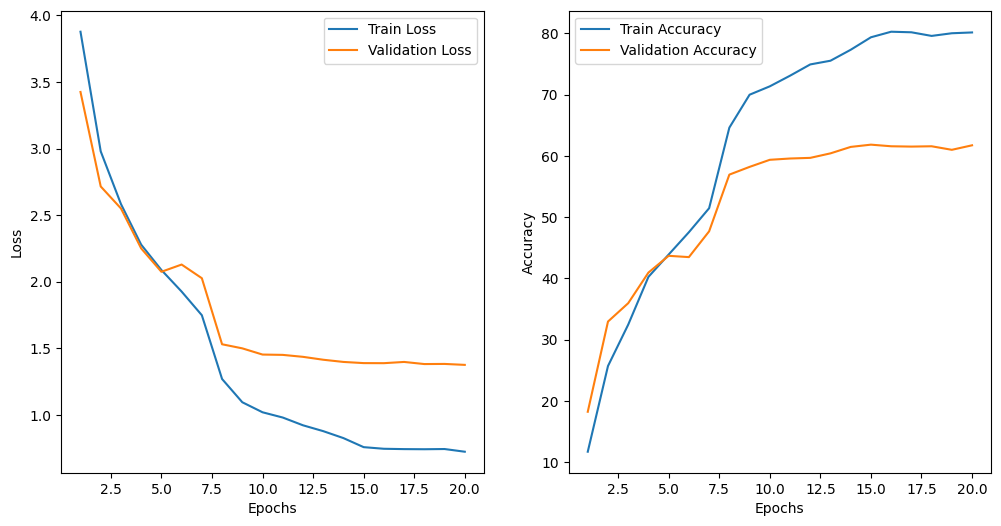

In [ ]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_3.csv", index=False)

print("Predictions saved to 'submission_3.csv'")

Predictions saved to 'submission_3.csv'


Всё, что ниже, для выбивания скора на каггле

In [ ]:
from torchvision import models, transforms
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 100)  # 100 классов
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.9776, Train Accuracy: 10.63%
Validation Loss: 3.3957, Validation Accuracy: 18.77%
Epoch 2/20, Train Loss: 2.9972, Train Accuracy: 25.35%
Validation Loss: 2.8826, Validation Accuracy: 31.23%
Epoch 3/20, Train Loss: 2.5004, Train Accuracy: 34.82%
Validation Loss: 2.4655, Validation Accuracy: 35.44%
Epoch 4/20, Train Loss: 2.1925, Train Accuracy: 41.10%
Validation Loss: 2.2292, Validation Accuracy: 41.64%
Epoch 5/20, Train Loss: 1.9772, Train Accuracy: 46.00%
Validation Loss: 2.0025, Validation Accuracy: 47.32%
Epoch 6/20, Train Loss: 1.7904, Train Accuracy: 49.93%
Validation Loss: 1.9502, Validation Accuracy: 47.79%
Epoch 7/20, Train Loss: 1.6335, Train Accuracy: 53.61%
Validation Loss: 1.9202, Validation Accuracy: 48.11%
Epoch 8/20, Train Loss: 1.1822, Train Accuracy: 66.68%
Validation Loss: 1.4247, Validation Accuracy: 60.78%
Epoch 9/20, Train Loss: 1.0146, Train Accuracy: 71.58%
Validation Loss: 1.3856, Validation Accuracy: 61.72%
Epoch 10/20, Train Loss: 0.9

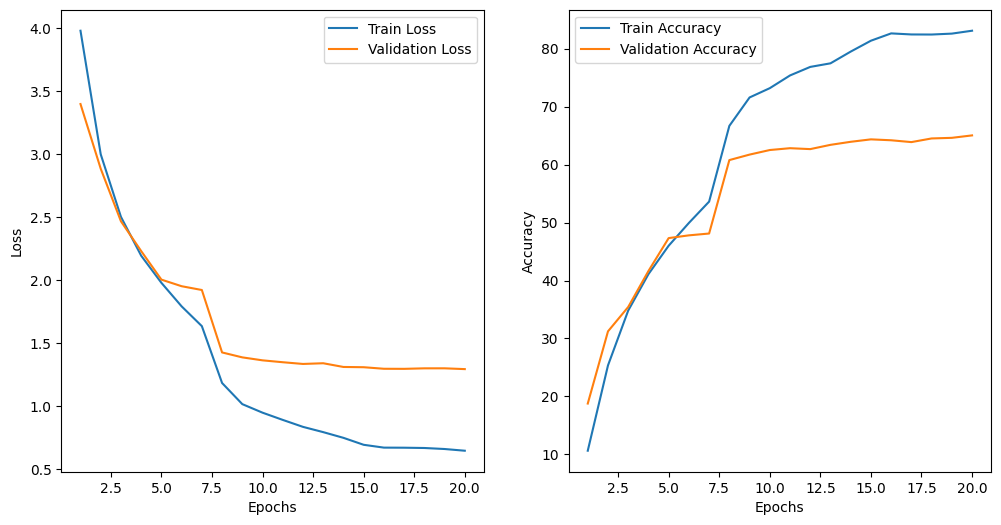

In [ ]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_4.csv", index=False)

print("Predictions saved to 'submission_4.csv'")

<ipython-input-19-edf617cc5ff5>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Predictions saved to 'submission_4.csv'
